In [28]:
import io
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

In [2]:
tf.__version__

'2.2.0-rc3'

# Download data

In [3]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

Check data

In [5]:
encoder = info.features['text'].encoder
encoder.subwords[-10:]

['Perso',
 'Patrick_',
 'Lei',
 'Jus',
 'Gho',
 'Get_',
 'Freeman',
 'Especially_',
 '?).',
 '..."']

In [8]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [9]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[1589, 3310,   49, ...,    0,    0,    0],
       [4344,    2,   12, ...,    0,    0,    0],
       [  19,   32,  732, ...,    0,    0,    0],
       ...,
       [1179,  439,    2, ...,    0,    0,    0],
       [7916,   64, 6539, ..., 5770,  100, 7975],
       [2517, 1368,   26, ...,    0,    0,    0]])

# Build model

In [10]:
embedding_dim=16

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.5071 - accuracy: 0.6956 - val_loss: 0.3788 - val_accuracy: 0.8500
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2827 - accuracy: 0.8840 - val_loss: 0.3163 - val_accuracy: 0.8650
Epoch 3/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2298 - accuracy: 0.9097 - val_loss: 0.3588 - val_accuracy: 0.8550
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1984 - accuracy: 0.9244 - val_loss: 0.3975 - val_accuracy: 0.8900
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1756 - accuracy: 0.9338 - val_loss: 0.2983 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1570 - accuracy: 0.9407 - val_loss: 0.3359 - val_accuracy: 0.8500
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1453 - accuracy: 0.9476 - val_loss: 0.4490 - val_accuracy:

Plot learning history

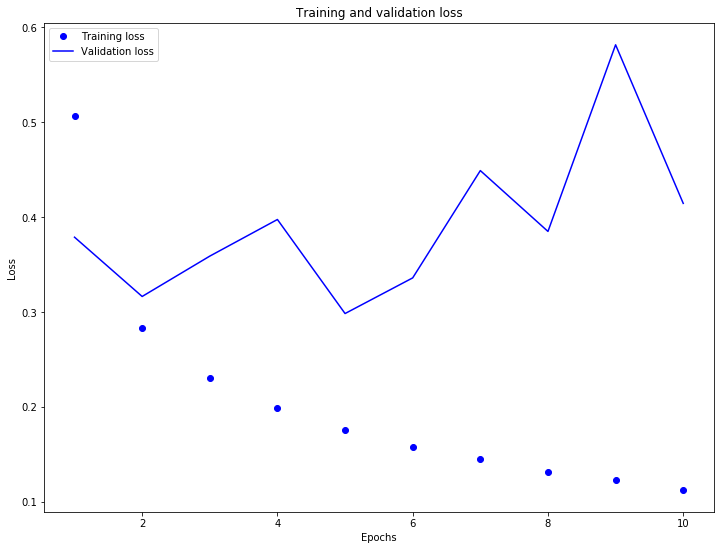

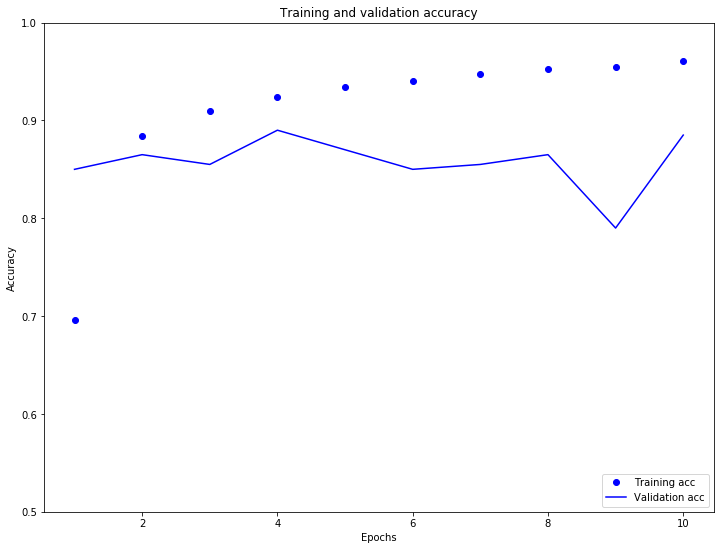

In [13]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()


In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


# Save weights

In [18]:
encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')


for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    embs.append((word, vec))
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [26]:
distances = pairwise_distances(weights, weights, metric='cosine')

In [49]:
sorted(list(zip(encoder.subwords, distances[encoder.subwords.index('good')])), key=lambda x: x[1])[-10:]

[('surface', 1.9988992),
 ('ct_', 1.9989471),
 ('Only_', 1.9989555),
 ('allo', 1.9989569),
 ('".<', 1.9989877),
 ('willing_', 1.9990008),
 ('Barry', 1.999052),
 ('ree', 1.9990554),
 ('completely_', 1.9990816),
 ('peace', 1.9992323)]